In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [2]:
atr_period = 10
multiplier = 3.0

In [3]:
symbol = 'AAPL'
df = yf.download(symbol, start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
high = df['High']
low = df['Low']
close = df['Close']

# ATR Calculation

In [5]:
# calculate ATR
price_diffs = [high - low, 
                high - close.shift(), 
                close.shift() - low]
true_range = pd.concat(price_diffs, axis=1)
true_range = true_range.abs().max(axis=1)
# default ATR calculation in supertrend indicator
atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean()

In [6]:
# HL2 is simply the average of high and low prices
hl2 = (high + low) / 2
# upperband and lowerband calculation
# notice that final bands are set to be equal to the respective bands
final_upperband = upperband = hl2 + (multiplier * atr)
final_lowerband = lowerband = hl2 - (multiplier * atr)

# Adjustment we need to make to the upper and lower bands to form the final bands

In [7]:
# initialize Supertrend column to True
supertrend = [True] * len(df)

for i in range(1, len(df.index)):
    curr, prev = i, i-1
    
    # if current close price crosses above upperband
    if close[curr] > final_upperband[prev]:
        supertrend[curr] = True
    # if current close price crosses below lowerband
    elif close[curr] < final_lowerband[prev]:
        supertrend[curr] = False
    # else, the trend continues
    else:
        supertrend[curr] = supertrend[prev]
        
        # adjustment to the final bands
        if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
            final_lowerband[curr] = final_lowerband[prev]
        if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
            final_upperband[curr] = final_upperband[prev]

    # to remove bands according to the trend direction
    if supertrend[curr] == True:
        final_upperband[curr] = np.nan
    else:
        final_lowerband[curr] = np.nan

In [8]:
supertrend = pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)

In [9]:
df = df.join(supertrend)

# Visualization

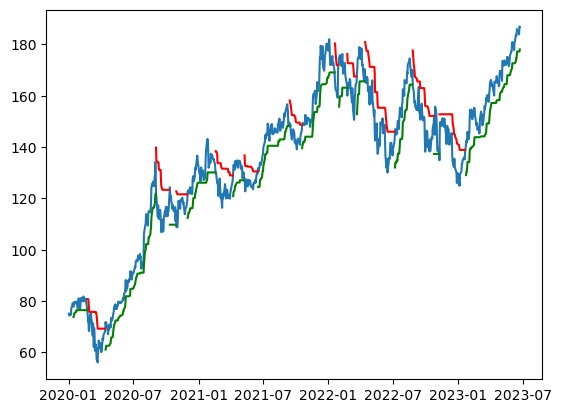

In [10]:
# visualization
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

# Backtesting

### Enter when the price movement is in the uptrend and exit when the trend direction changes.

In [11]:
investment = 100000
is_uptrend = df['Supertrend']
close = df['Close']

# initial condition
in_position = False
equity = investment
commission = 5
share = 0
entry = []
exit = []

In [12]:
for i in range(2, len(df)):
    # if not in position & price is on uptrend -> buy
    if not in_position and is_uptrend[i]:
        share = math.floor(equity / close[i] / 100) * 100
        equity -= share * close[i]
        entry.append((i, close[i]))
        in_position = True
        print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if in position & price is not on uptrend -> sell
    elif in_position and not is_uptrend[i]:
        equity += share * close[i] - commission
        exit.append((i, close[i]))
        in_position = False
        print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')


Buy 1300 shares at 74.95 on 2020/01/06
Sell at 74.54 on 2020/02/24
Buy 1300 shares at 71.76 on 2020/04/14
Sell at 120.88 on 2020/09/03
Buy 1300 shares at 124.4 on 2020/10/12
Sell at 108.86 on 2020/10/30
Buy 1100 shares at 122.72 on 2020/12/01
Sell at 129.71 on 2021/02/18
Buy 1100 shares at 130.36 on 2021/04/08
Sell at 126.85 on 2021/05/10
Buy 1100 shares at 131.79 on 2021/06/17
Sell at 148.12 on 2021/09/14
Buy 1100 shares at 148.76 on 2021/10/19
Sell at 166.23 on 2022/01/19
Buy 1000 shares at 174.78 on 2022/01/31
Sell at 160.07 on 2022/02/23
Buy 1000 shares at 168.82 on 2022/03/22
Sell at 165.29 on 2022/04/14
Buy 1100 shares at 146.35 on 2022/07/07
Sell at 163.62 on 2022/08/26
Buy 1200 shares at 152.34 on 2022/10/25
Sell at 134.87 on 2022/11/09
Buy 1100 shares at 141.11 on 2023/01/23


In [13]:
# if still in position -> sell all share 
if in_position:
    equity += share * close[i] - commission

earning = equity - investment
roi = round(earning/investment*100,2)
print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')

Earning from investing $100k is $113992.23 (ROI = 113.99%)


# Creating the function for SuperTrend

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
atr_period = 10
atr_multiplier = 3.0

symbol = 'AAPL'
df = yf.download(symbol, start='2020-01-01')
supertrend = Supertrend(df, atr_period, atr_multiplier)
df = df.join(supertrend)

[*********************100%***********************]  1 of 1 completed


# Backtesting

In [24]:
# a simple backtesting on the Supertrend indicator - Enter when the price movement is in the uptrend and exit when the trend direction changes.

def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity
entry, exit, roi = backtest_supertrend(df, 100000)

Buy 1300 shares at 74.95 on 2020/01/06
Sell at 74.54 on 2020/02/24
Buy 1300 shares at 71.76 on 2020/04/14
Sell at 120.88 on 2020/09/03
Buy 1300 shares at 124.4 on 2020/10/12
Sell at 108.86 on 2020/10/30
Buy 1100 shares at 122.72 on 2020/12/01
Sell at 129.71 on 2021/02/18
Buy 1100 shares at 130.36 on 2021/04/08
Sell at 126.85 on 2021/05/10
Buy 1100 shares at 131.79 on 2021/06/17
Sell at 148.12 on 2021/09/14
Buy 1100 shares at 148.76 on 2021/10/19
Sell at 166.23 on 2022/01/19
Buy 1000 shares at 174.78 on 2022/01/31
Sell at 160.07 on 2022/02/23
Buy 1000 shares at 168.82 on 2022/03/22
Sell at 165.29 on 2022/04/14
Buy 1100 shares at 146.35 on 2022/07/07
Sell at 163.62 on 2022/08/26
Buy 1200 shares at 152.34 on 2022/10/25
Sell at 134.87 on 2022/11/09
Buy 1100 shares at 141.11 on 2023/01/23
Earning from investing $100k is $113992.23 (ROI = 113.99%)


# Screening for SuperTrend
### To hunt for stocks on which we can apply the strategy.


In [17]:
# looking through each symbol in the S&P 500 stock list and filter out those that have just entered the Supertrend.

# get the full stock list of S&P 500
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_list = payload[0]['Symbol'].values.tolist()
supertrend_stocks = []
# loop through each symbol
for symbol in stock_list:
    df = yf.download(symbol, start='2010-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2023-06-24)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Parameter Optimization

In [25]:
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0]
    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])
df = yf.download('TSLA', start='2010-01-01')
optimal_param = find_optimal_parameter(df)
print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')

[*********************100%***********************]  1 of 1 completed
Buy 82600 shares at 1.21 on 2010/07/13
Sell at 1.31 on 2010/08/06
Buy 86200 shares at 1.25 on 2010/08/16
Sell at 1.34 on 2010/09/10
Buy 82300 shares at 1.41 on 2010/09/14
Sell at 1.35 on 2010/09/17
Buy 77800 shares at 1.43 on 2010/09/28
Sell at 1.36 on 2010/09/30
Buy 76200 shares at 1.39 on 2010/10/25
Sell at 1.42 on 2010/11/02
Buy 65000 shares at 1.66 on 2010/11/04
Sell at 2.16 on 2010/12/02
Buy 67000 shares at 2.09 on 2010/12/17
Sell at 2.01 on 2010/12/23
Buy 71400 shares at 1.88 on 2011/01/07
Sell at 1.8 on 2011/01/11
Buy 78600 shares at 1.63 on 2011/01/24
Sell at 1.58 on 2011/02/03
Buy 75900 shares at 1.63 on 2011/02/08
Sell at 1.52 on 2011/02/15
Buy 70100 shares at 1.65 on 2011/02/16
Sell at 1.55 on 2011/02/18
Buy 68800 shares at 1.57 on 2011/02/25
Sell at 1.6 on 2011/03/10
Buy 71000 shares at 1.55 on 2011/03/28
Sell at 1.72 on 2011/04/04
Buy 68600 shares at 1.78 on 2011/04/21
Sell at 1.78 on 2011/05/04
Buy 65600

Buy 82600 shares at 1.21 on 2010/07/13
Sell at 1.17 on 2010/08/12
Buy 69100 shares at 1.4 on 2010/09/02
Sell at 1.9 on 2010/12/14
Buy 71000 shares at 1.85 on 2011/03/31
Sell at 1.73 on 2011/06/20
Buy 70000 shares at 1.76 on 2011/09/23
Sell at 1.96 on 2011/12/13
Buy 66200 shares at 2.08 on 2012/02/03
Sell at 2.21 on 2012/04/09
Buy 64900 shares at 2.25 on 2012/06/20
Sell at 1.99 on 2012/07/24
Buy 62200 shares at 2.08 on 2012/08/13
Sell at 1.84 on 2012/09/25
Buy 54600 shares at 2.1 on 2012/11/05
Sell at 2.34 on 2013/02/21
Buy 49100 shares at 2.61 on 2013/03/11
Sell at 2.35 on 2013/03/15
Buy 39400 shares at 2.93 on 2013/04/01
Sell at 7.27 on 2013/07/16
Buy 29700 shares at 9.65 on 2013/08/05
Sell at 11.25 on 2013/10/09
Buy 34600 shares at 9.65 on 2013/12/03
Sell at 14.2 on 2014/03/26
Buy 32800 shares at 14.97 on 2014/06/16
Sell at 14.6 on 2014/07/08
Buy 28900 shares at 16.6 on 2014/08/06
Sell at 16.92 on 2014/09/15
Buy 28300 shares at 17.25 on 2014/11/14
Sell at 15.44 on 2014/12/01
Buy 2880

Buy 75600 shares at 1.32 on 2010/07/14
Sell at 1.19 on 2010/08/11
Buy 66100 shares at 1.36 on 2010/09/01
Sell at 1.9 on 2010/12/14
Buy 75600 shares at 1.66 on 2011/03/04
Sell at 1.48 on 2011/03/22
Buy 60400 shares at 1.85 on 2011/03/31
Sell at 1.77 on 2011/06/16
Buy 53900 shares at 1.98 on 2011/07/07
Sell at 1.65 on 2011/08/04
Buy 51700 shares at 1.72 on 2011/09/16
Sell at 2.03 on 2011/12/12
Buy 51900 shares at 2.02 on 2012/02/02
Sell at 2.21 on 2012/04/09
Buy 53600 shares at 2.14 on 2012/06/19
Sell at 2.04 on 2012/07/23
Buy 52800 shares at 2.08 on 2012/08/13
Sell at 1.84 on 2012/09/25
Buy 46300 shares at 2.1 on 2012/11/05
Sell at 2.34 on 2013/02/21
Buy 42300 shares at 2.56 on 2013/03/08
Sell at 2.35 on 2013/03/15
Buy 34000 shares at 2.93 on 2013/04/01
Sell at 7.27 on 2013/07/16
Buy 27500 shares at 8.97 on 2013/07/29
Sell at 11.55 on 2013/10/03
Buy 32900 shares at 9.65 on 2013/12/03
Sell at 14.68 on 2014/03/24
Buy 34300 shares at 14.1 on 2014/05/27
Sell at 14.84 on 2014/07/07
Buy 32000

Buy 75400 shares at 1.33 on 2010/07/15
Sell at 1.19 on 2010/08/11
Buy 66000 shares at 1.36 on 2010/09/01
Sell at 1.9 on 2010/12/14
Buy 75400 shares at 1.66 on 2011/03/04
Sell at 1.48 on 2011/03/22
Buy 60300 shares at 1.85 on 2011/03/31
Sell at 1.77 on 2011/06/16
Buy 53700 shares at 1.98 on 2011/07/07
Sell at 1.65 on 2011/08/04
Buy 51600 shares at 1.72 on 2011/09/16
Sell at 2.03 on 2011/12/12
Buy 51800 shares at 2.02 on 2012/02/02
Sell at 2.3 on 2012/04/05
Buy 56100 shares at 2.12 on 2012/06/18
Sell at 2.04 on 2012/07/23
Buy 55200 shares at 2.08 on 2012/08/13
Sell at 1.84 on 2012/09/25
Buy 48500 shares at 2.1 on 2012/11/05
Sell at 2.34 on 2013/02/21
Buy 44300 shares at 2.56 on 2013/03/08
Sell at 2.35 on 2013/03/15
Buy 35600 shares at 2.93 on 2013/04/01
Sell at 7.27 on 2013/07/16
Buy 28800 shares at 8.97 on 2013/07/29
Sell at 11.55 on 2013/10/03
Buy 34500 shares at 9.65 on 2013/12/03
Sell at 14.68 on 2014/03/24
Buy 35900 shares at 14.1 on 2014/05/27
Sell at 14.84 on 2014/07/07
Buy 33500 

Buy 72600 shares at 1.38 on 2010/07/16
Sell at 1.9 on 2010/12/14
Buy 74600 shares at 1.85 on 2011/03/31
Sell at 1.73 on 2011/06/20
Buy 72000 shares at 1.8 on 2011/10/06
Sell at 1.96 on 2011/12/13
Buy 68100 shares at 2.08 on 2012/02/03
Sell at 2.21 on 2012/04/09
Buy 66800 shares at 2.25 on 2012/06/20
Sell at 1.99 on 2012/07/24
Buy 64000 shares at 2.08 on 2012/08/13
Sell at 1.84 on 2012/09/25
Buy 56100 shares at 2.1 on 2012/11/05
Sell at 2.34 on 2013/02/21
Buy 50500 shares at 2.61 on 2013/03/11
Sell at 2.35 on 2013/03/15
Buy 40500 shares at 2.93 on 2013/04/01
Sell at 7.27 on 2013/07/16
Buy 32000 shares at 9.2 on 2013/08/02
Sell at 11.25 on 2013/10/09
Buy 37300 shares at 9.65 on 2013/12/03
Sell at 14.2 on 2014/03/26
Buy 35300 shares at 14.97 on 2014/06/16
Sell at 14.6 on 2014/07/08
Buy 31100 shares at 16.6 on 2014/08/06
Sell at 16.92 on 2014/09/15
Buy 30500 shares at 17.25 on 2014/11/14
Sell at 15.44 on 2014/12/01
Buy 31000 shares at 15.19 on 2014/12/26
Sell at 13.48 on 2015/01/12
Buy 288

### Running the test on TSLA from Jan 2010 to Sep 2021 shows that the best parameter set for Supertrend is atr_period=7 & multiplier=2.5 .